# 2. New York Taxi Trip EDA and Baseline Model

출처 : [뉴욕 택시 여행 EDA and Model](https://www.kaggle.com/aiswaryaramachandran/eda-baseline-model-0-40-rmse)

In [1]:
# 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')

from datetime import datetime, timedelta
import calendar
from math import sin, cos, sqrt, atan2 , radians

import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import folium.plugins

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 불러오기
train = pd.read_csv('data/newyork_train.csv')
test = pd.read_csv('data/newyork_test.csv')
print(test.shape)

(625134, 9)


In [3]:
# 데이터 타입 변경
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### 결측치 확인

In [4]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Missing value는 없다.

In [5]:
print('Min pick up time: ', min(train['pickup_datetime']))
print('Max pick up time: ', max(train['pickup_datetime']))

Min pick up time:  2016-01-01 00:00:17
Max pick up time:  2016-06-30 23:59:39


1월부터 6월까지의 데이터로 보인다.

## 파생변수 생성

In [6]:
# 승차 변수를 통해 새로운 feature 생성
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_day_of_week'] = train['pickup_datetime'].dt.weekday

# 하차 변수를 통해 새로운 feature 생성
train['dropoff_date'] = pd.to_datetime(train['dropoff_datetime'])
train['dropoff_day'] = train['dropoff_datetime'].dt.day
train['dropoff_hour'] = train['dropoff_datetime'].dt.hour
train['dropoff_day_of_week'] = train['dropoff_datetime'].dt.weekday

In [7]:
# 라운딩
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(lambda x : round(x, 3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(lambda x : round(x ,3))

train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(lambda x: round(x, 3))
train['dropoff_longitude_round3'] = train['dropoff_longitude'].apply(lambda x : round(x , 3))

In [8]:
# 거리를 구하는 함수
def calculateDistance(row):
    R = 6373.0
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    
    a = sin(dlat / 2) ** 2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R  * c
    
    return distance

In [9]:
# 위에서 만든 함수를 적용함
train['trip_distance'] = train.apply(lambda row : calculateDistance(row), axis = 1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,2016-03-14 17:32:30,14,17,0,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6,2016-06-12 00:54:38,12,0,6,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,1,2016-01-19 12:10:48,19,12,1,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2,2016-04-06 19:39:40,6,19,2,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5,2016-03-26 13:38:10,26,13,5,40.793,-73.973,40.783,-73.973,1.188962


In [10]:
train['trip_duration_in_hour'] = train['trip_duration'].apply(lambda x : x/3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14 17:32:30,14,17,0,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12 00:54:38,12,0,6,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19 12:10:48,19,12,1,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06 19:39:40,6,19,2,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26 13:38:10,26,13,5,40.793,-73.973,40.783,-73.973,1.188962,0.120833


## EDA

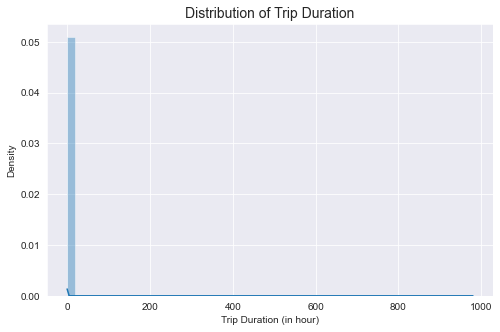

In [11]:
plt.figure(figsize = (8,5))
sns.distplot(train['trip_duration_in_hour'])
plt.title('Distribution of Trip Duration', size = 14)
plt.xlabel('Trip Duration (in hour)')
plt.show()

In [12]:
print('trip duration in hour의 중앙값' ,round(train['trip_duration_in_hour'].median(), 3))
print('trip distance의 중앙값', round(train['trip_distance'].median(), 3))

trip duration in hour의 중앙값 0.184
trip distance의 중앙값 2.094


trip_duration_in_hour의 중앙값은 0.184인데 그래프를 보면 미약하게 이상치가 보인다. 자세히 살펴보겠다.

In [13]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27 11:08:38,27,11,2,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08 15:57:38,8,15,1,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31 01:01:07,31,1,6,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25 18:18:14,25,18,4,40.649,-73.784,40.750,-73.978,19.906909,979.522778


다음 4개의 데이터들이 24 시간을 넘는 trip duration을 보였다. 시간은 매우 높지만 주행거리(trip_distance)가 높지는 않은 데이터도 보인다. 위 4개의 데이터를 이상치로 취급하자. 하지만  위 데이터들이 특정 지역에서 출발하거나 끝나는지 궁금하다. 

그전에 trip distance가 매우 skew 되어있기 때문에 로그 변환을 취해 정규성을 갖도록 해주자.

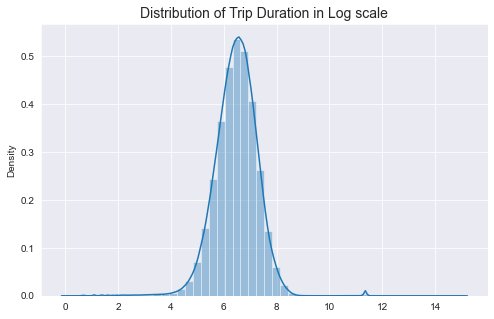

In [14]:
plt.figure(figsize = (8,5))
sns.distplot(np.log(train['trip_duration'].values))
plt.title('Distribution of Trip Duration in Log scale', size = 14)
plt.show()

In [15]:
print('Trip Duration (log scale)의 평균: ',np.log(train['trip_duration']).mean())
print('New York Taxi의 평균 trip duration은 {}분이다.'.format(round(np.exp(6.49) / 60, 3)))

Trip Duration (log scale)의 평균:  6.464521175262891
New York Taxi의 평균 trip duration은 10.975분이다.


로그 변환을 해주니 정규성을 갖는 분포를 보인다. 대부분의 데이터가 4~6 사이에 분포하고 있다. 이를 exponential을 취해주어 확인해보면 54초 ~ 50분 안에 trip을 마친다는 뜻이다.  하지만 분포의 끝에 있는 데이터들처럼 100시간이 넘게 택시를 탄다는 것은 말이 되지 않는다.

### 히트맵 Heatmap

In [16]:
# 위도와 경도를 이용하여 pick up이라는 데이터프레임 생성
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['id'].count().reset_index().rename(columns = {'id' : 'Num_Trips'})
pickup.head()

,pickup_latitude_round3,pickup_longitude_round3,Num_Trips
0,34.360,-65.848,1
1,34.712,-75.354,1
2,35.082,-71.800,1
3,35.310,-72.074,1
4,36.029,-77.441,1


In [17]:
# folium으로 공간 시각화 해주기
pickup_map = folium.Map(location=[40.730610, -73.935242], zoom_start=12,)

hm_wide = HeatMap(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Num_Trips),
                     min_opacity=0.5,
                     radius=5,
                     blur=10,
                     max_zoom=10)

pickup_map.add_child(hm_wide)
pickup_map

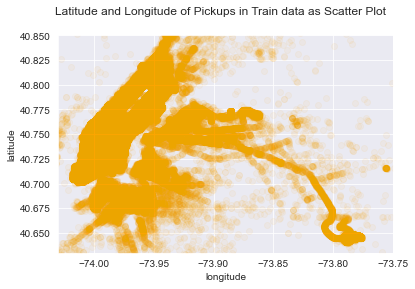

In [18]:
# 뉴욕의 위도, 경도의 경계라인 설정해주기
city_log_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# scatterplot 그리기
fig, ax = plt.subplots(ncols = 1, sharex = True, sharey = True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'], color = 'orange', label = 'train', alpha = 0.05)
fig.suptitle('Latitude and Longitude of Pickups in Train data as Scatter Plot')
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_log_border)
plt.show()

In [19]:
# 위도와 경도를 사용하여 drop이라는 새로운 데이터 프레임 생성
drop=train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [20]:
# folium으로 공간 시각화 해주기
drop_map = folium.Map(location=[40.730610, -73.935242], zoom_start=12,)

hm_wide = HeatMap(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips),
                     min_opacity=0.5,
                     radius=5,
                     blur=10,
                     max_zoom=10)

drop_map.add_child(hm_wide)
drop_map

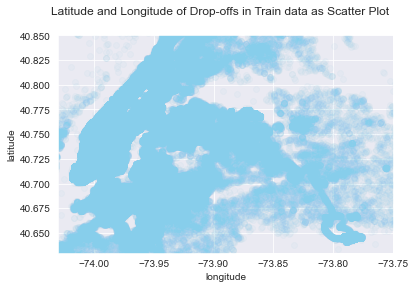

In [21]:
# 뉴욕의 위도, 경도의 경계라인 설정해주기
city_log_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# scatterplot 그리기
fig, ax = plt.subplots(ncols = 1, sharex = True, sharey = True)
ax.scatter(train['dropoff_longitude'], train['dropoff_latitude'], color = 'skyblue', label = 'train', alpha = 0.05)
fig.suptitle('Latitude and Longitude of Drop-offs in Train data as Scatter Plot')
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_log_border)
plt.show()

pickup보다 상대적으로 외곽지역에서도 많은 점들이 보인다.

### 시간대에 따라

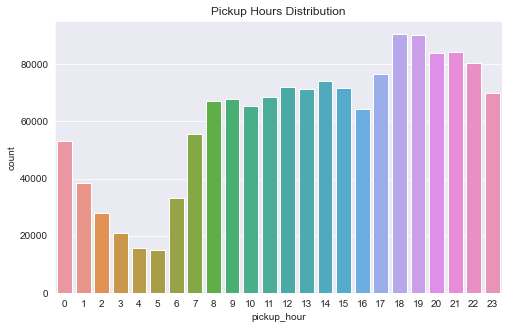

In [22]:
# 승차객
plt.figure(figsize = (8,5))
sns.countplot( x= train['pickup_hour']).set_title('Pickup Hours Distribution')
plt.show()

저녁 6시부터 저녁 10시까지 승차객이 많은 것을 확인 할 수 있다.

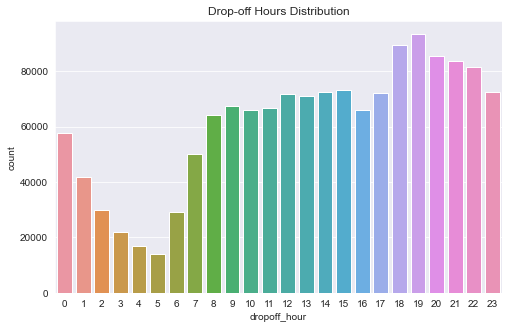

In [23]:
# 하차객
plt.figure(figsize = (8,5))
sns.countplot(x = train['dropoff_hour']).set_title('Drop-off Hours Distribution')
plt.show()

하차객의 시간대별 분포도 승차객의 시간대별 분포와 유사하게 보인다.

In [24]:
train['pickup_day_of_week'].value_counts()

4    223533
5    220868
3    218574
2    210136
1    202749
6    195366
0    187418
Name: pickup_day_of_week, dtype: int64

In [25]:
# 요일을 담은 list 생성
dayofweek = train['pickup_day_of_week'].replace({0 : 'Mon', 1 : 'Tue', 2 : 'Wed', 3 : 'Thu', 4 : 'Fri', 5 : 'Sat', 6 : 'Sun'})

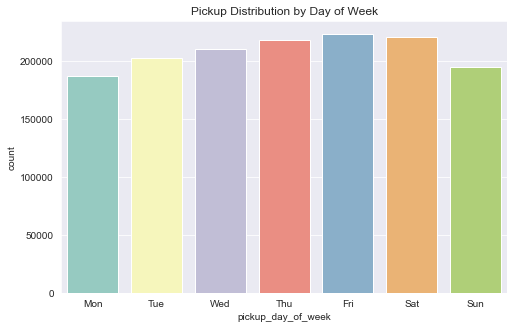

In [26]:
# 요일에 따라
plt.figure(figsize = (8,5))
sns.countplot(x = dayofweek, palette='Set3', order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']).set_title('Pickup Distribution by Day of Week')
plt.show()

### Create a calculated field Bearing

Bearing measures the direction of travel The formula is: θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ ) λ is the longitude

왜 하는지 이해가 잘 가지 않음..

In [27]:
# bearing(방향)을 계산하는 함수
def calculateBearing(lat1, lng1, lat2, lng2):
    R = 6371
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng2, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    
    return np.degrees(np.arctan2(y, x))

In [28]:
train['bearing'] = train.apply(lambda row : calculateBearing(row['pickup_latitude_round3'],
                                                             row['pickup_longitude_round3'], 
                                                             row['dropoff_latitude_round3'], 
                                                             row['dropoff_longitude_round3']), axis = 1)

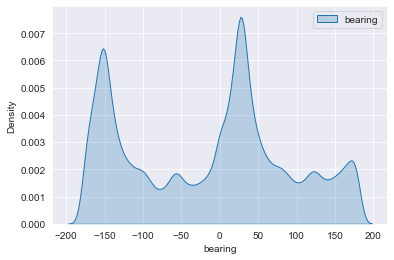

In [29]:
sns.kdeplot(train['bearing'], fill = True, label='bearing')
plt.legend()
plt.show()

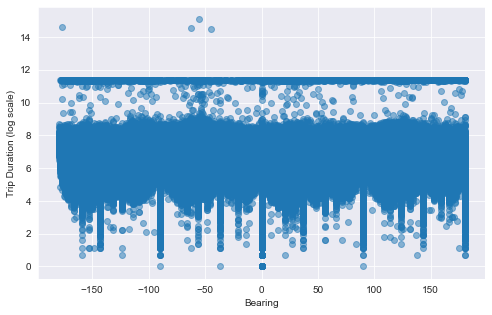

In [30]:
# Bearing vs Trip duration
plt.figure(figsize = (8,5))
plt.scatter(train['bearing'].values, y = np.log(train['trip_duration'].values), alpha = 0.5)
plt.xlabel('Bearing')
plt.ylabel('Trip Duration (log scale)')
plt.show()

이상치로 보이는 값들이 -50 이하로만 분포하고 있다.

### Store and FWD Flag

This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server 
- Y=store and forward
- N=not a store and forward trip

In [31]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

No의 비율이 압도적으로 많은 것을 확인 할 수 있다.

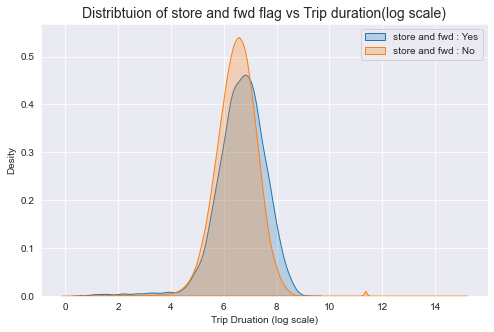

In [32]:
plt.figure(figsize = (8,5))
# store and fwd flag가 yes인 kde plot
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag'] == 'Y', 'trip_duration']), label = 'store and fwd : Yes', fill = True)
# store and fwd flag가 No인 kde plot
sns.kdeplot(np.log(train.loc[train['store_and_fwd_flag'] == 'N', 'trip_duration']), label = 'store and fwd : No', fill = True)

plt.title('Distribtuion of store and fwd flag vs Trip duration(log scale)', size = 14)
plt.xlabel('Trip Druation (log scale)')
plt.ylabel('Desity')
plt.legend()
plt.show()

### Clustering

In [33]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values, train[['dropoff_latitude', 'dropoff_longitude']].values,
                   test[['pickup_latitude', 'pickup_longitude']].values, test[['dropoff_latitude', 'dropoff_longitude']].values))
coords

array([[ 40.76793671, -73.98215485],
       [ 40.73856354, -73.98041534],
       [ 40.7639389 , -73.97902679],
       ...,
       [ 40.74866486, -73.87660217],
       [ 40.89178848, -73.85426331],
       [ 40.76937866, -73.96932983]])

In [34]:
# vstack 예시
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
np.vstack((a,b))

array([[1, 2, 3],
       [4, 5, 6]])

In [35]:
# kmeans 객체 생성
kmeans = KMeans(n_clusters=8, random_state = 0).fit(coords)
train.loc[:, 'pickup_neighborhood'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_neighborhood'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])

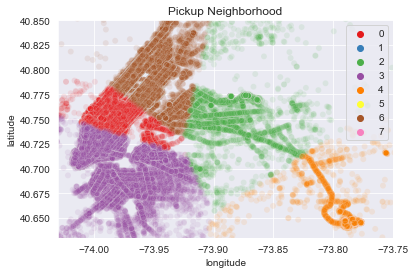

In [36]:
# cluster에 따른 scatter plot (pick up)
sns.scatterplot(train['pickup_longitude'], train['pickup_latitude'], #c = train['pickup_neighborhood']
                hue = train['pickup_neighborhood'] , alpha = 0.1, palette = 'Set1')
plt.title('Pickup Neighborhood');plt.xlabel('longitude');plt.ylabel('latitude')
plt.xlim(city_log_border); plt.ylim(city_lat_border)
plt.legend()
plt.show()

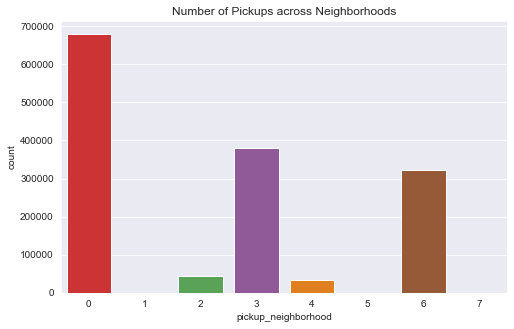

In [37]:
plt.figure(figsize = (8,5))
sns.countplot(train['pickup_neighborhood'], palette='Set1').set_title('Number of Pickups across Neighborhoods')
plt.show()

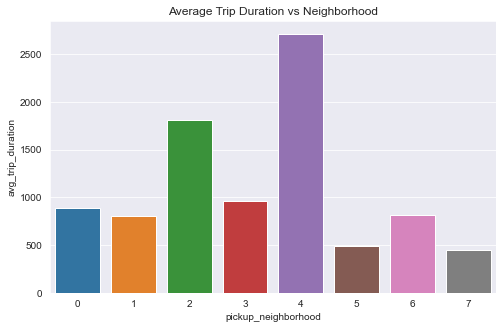

In [38]:
avg_duration_neighborhood = train.groupby(['pickup_neighborhood'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration' : 'avg_trip_duration'})

plt.figure(figsize = (8,5))
sns.barplot(x = 'pickup_neighborhood', y = 'avg_trip_duration', data = avg_duration_neighborhood).set_title('Average Trip Duration vs Neighborhood')
plt.show()

2, 4번 cluster의 average trip duration이 길어도 0번의 cluster가 가장 많았다.

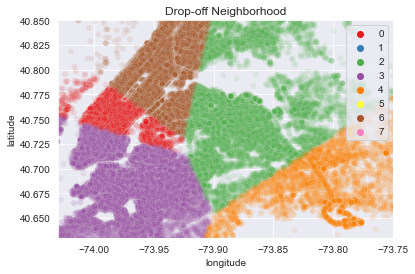

In [39]:
# cluster에 따른 scatter plot (drop-off)
sns.scatterplot(train['dropoff_longitude'], train['dropoff_latitude'], #c = train['pickup_neighborhood']
                hue = train['dropoff_neighborhood'] , alpha = 0.1, palette = 'Set1')
plt.title('Drop-off Neighborhood');plt.xlabel('longitude');plt.ylabel('latitude')
plt.xlim(city_log_border); plt.ylim(city_lat_border)
plt.legend()
plt.show()

위에서 보았듯 pickup과 dropoff의 분포는 조금 다른 것으로 보인다. pickup 산점도에서 잘 드러나지 않았던 2번 cluster와 4번 cluster가 두드러져 보인다.

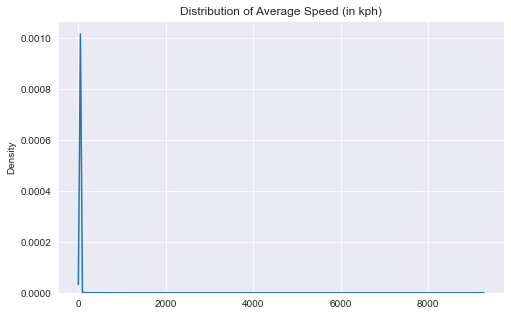

In [40]:
# 평균 주행 속도 구하기
train['avg_speed_kph'] = train['trip_distance'] / train['trip_duration_in_hour']

# kde plot 그리기
plt.figure(figsize = (8,5))
sns.kdeplot(train['avg_speed_kph'].values).set_title('Distribution of Average Speed (in kph)')
plt.show()

In [41]:
# 평균 주행 속도
print('Average Speed is', np.mean(train['avg_speed_kph']), 'kph')

Average Speed is 14.427736738458588 kph


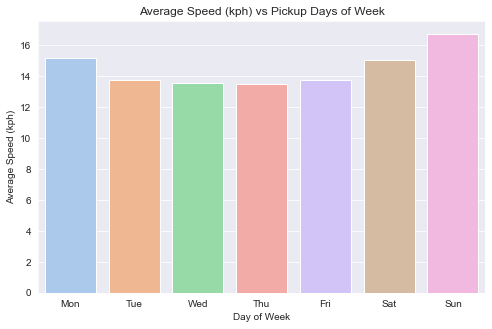

In [42]:
# 요일에 따른 평균 주행 속도
avg_speed_per_day = train.groupby(['pickup_day_of_week'])['avg_speed_kph'].mean().reset_index()
avg_speed_per_day['pickup_day_of_week'].replace({0 : 'Mon', 1 : 'Tue', 2 : 'Wed', 3 : 'Thu', 4 : 'Fri', 5 : 'Sat', 6 : 'Sun'}, inplace = True)
plt.figure(figsize = (8,5))
sns.barplot(x = 'pickup_day_of_week', y = 'avg_speed_kph', data = avg_speed_per_day, palette = 'pastel').set_title('Average Speed (kph) vs Pickup Days of Week')
plt.ylabel('Average Speed (kph)')
plt.xlabel('Day of Week')
plt.show()

평균 주행 속도는 일요일, 월요일, 토요일이 높은 것으로 나타났다.